## starter notebook of brown spots predictions on passion fruit from zindi competetion being adapted to violence detection on women faces
##the code uses faster rcnn backboned with resnet50 from torchVision 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2
import ast

import numpy as np 
import pandas as pd 

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as immg

import random

import torch

import torchvision
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings("ignore")

unzipping the scraped data

In [3]:
"""
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Zindi mentorship program project (1).zip", 'r')
zip_ref.extractall("/content/drive/MyDrive/zindi_gbv")
zip_ref.close()
"""

### Read the csv files

### Train

In [3]:
train_df=pd.read_csv('/content/drive/MyDrive/zindi_gbv/Zindi mentorship program project/Datasets/Train/annos/train_annotations.csv',names=['class','xmin','ymin','width','height','Image_ID','imgW','imgH'])
train_df.head()

class  xmin  ymin  width  height  Image_ID  imgW  imgH
0  violenced    98     5     95      93  0001.jpg   340   340
1  violenced   188   127     28      42  0001.jpg   340   340
2  violenced    71   128     91      54  0001.jpg   340   340
3  violenced   226   119     84      49  0001.jpg   340   340
4  violenced   208   235     35      36  0001.jpg   340   340

In [4]:
train_df.shape

(461, 8)

In [5]:
No_duplicates = train_df.drop_duplicates(subset="Image_ID")
print(No_duplicates.shape)

(307, 8)


We have 307 bounding boxes, from a collection of 461 images. Some images have 1 bounding box, while others have more than 1 bounding box.

In [6]:
remove_col1 = train_df.pop('imgW')
remove_col2 = train_df.pop('imgH')


In [7]:
train_df.head()

class  xmin  ymin  width  height  Image_ID
0  violenced    98     5     95      93  0001.jpg
1  violenced   188   127     28      42  0001.jpg
2  violenced    71   128     91      54  0001.jpg
3  violenced   226   119     84      49  0001.jpg
4  violenced   208   235     35      36  0001.jpg

### Test

In [8]:
test_df = pd.read_csv("/content/drive/MyDrive/zindi_gbv/Zindi mentorship program project/Datasets/Test/annos/test_annoations.csv",names=['class','xmin','ymin','width','height','Image_ID','imgW','imgH'])
test_df.head()

class  xmin  ymin  width  height  Image_ID  imgW  imgH
0  violenced    79   121    208     167  0001.jpg   474   474
1  violenced    27   198    392     301  0002.jpg   474   577
2  violenced   198    60    251     124  0002.jpg   474   577
3  violenced   163   173     71      34  0003.jpg   474   452
4  violenced   198   244     31      25  0003.jpg   474   452

In [9]:
test_df.shape

(74, 8)

### data preprocessing
- Calculate the xmax and ymax from the train data

In [10]:
train_df['xmax'] = train_df['xmin']+train_df['width']
train_df['ymax'] = train_df['ymin']+train_df['height']

In [11]:
train_df.head()

class  xmin  ymin  width  height  Image_ID  xmax  ymax
0  violenced    98     5     95      93  0001.jpg   193    98
1  violenced   188   127     28      42  0001.jpg   216   169
2  violenced    71   128     91      54  0001.jpg   162   182
3  violenced   226   119     84      49  0001.jpg   310   168
4  violenced   208   235     35      36  0001.jpg   243   271

- Encode the classes from str to int

In [12]:
classes_la = {"violenced": 1, "unviolenced": 2}

train_df["class"] = train_df["class"].apply(lambda x: classes_la[x])

In [13]:
def del_jpg(x):
  x=str(x)
  x=x[:4]
  return x

In [14]:
train_df["Image_ID"] = train_df["Image_ID"].apply(lambda x: del_jpg(x))

In [15]:
train_df.head()

class  xmin  ymin  width  height Image_ID  xmax  ymax
0      1    98     5     95      93     0001   193    98
1      1   188   127     28      42     0001   216   169
2      1    71   128     91      54     0001   162   182
3      1   226   119     84      49     0001   310   168
4      1   208   235     35      36     0001   243   271

- Most pretrained models reserve label 0 for the background class, therefore we encoded our labels from 1

In [16]:
df = train_df.copy() # create a copy of the train df

### Visualization

- Let's create sample plots for our Image and the corresponding bounding box

In [17]:
path = '/content/drive/MyDrive/zindi_gbv/Zindi mentorship program project/Datasets/Train/images/'

In [18]:
# group by all bounding boxes (bbox)
df_grp = df.groupby(['Image_ID'])

In [19]:
def plot_image(image_name):
    image_group = df_grp.get_group(image_name)
    bbox = image_group.loc[:,['xmin', 'ymin', 'xmax', 'ymax']]
    img = immg.imread(path+name+'.jpg')
    fig,ax = plt.subplots(figsize=(18,10))
    ax.imshow(img,cmap='binary')
    for i in range(len(bbox)):
        box = bbox.iloc[i].values
        print(bbox)
        x,y,w,h = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = matplotlib.patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='r',facecolor='none',)
        ax.text(*box[:2], image_group["class"].values, verticalalignment='top', color='white', fontsize=13, weight='bold')
        ax.add_patch(rect)
    plt.show()

   xmin  ymin  xmax  ymax
0    98     5   193    98
1   188   127   216   169
2    71   128   162   182
3   226   119   310   168
4   208   235   243   271
5   188   274   249   309
   xmin  ymin  xmax  ymax
0    98     5   193    98
1   188   127   216   169
2    71   128   162   182
3   226   119   310   168
4   208   235   243   271
5   188   274   249   309
   xmin  ymin  xmax  ymax
0    98     5   193    98
1   188   127   216   169
2    71   128   162   182
3   226   119   310   168
4   208   235   243   271
5   188   274   249   309
   xmin  ymin  xmax  ymax
0    98     5   193    98
1   188   127   216   169
2    71   128   162   182
3   226   119   310   168
4   208   235   243   271
5   188   274   249   309
   xmin  ymin  xmax  ymax
0    98     5   193    98
1   188   127   216   169
2    71   128   162   182
3   226   119   310   168
4   208   235   243   271
5   188   274   249   309
   xmin  ymin  xmax  ymax
0    98     5   193    98
1   188   127   216   169
2    71   12

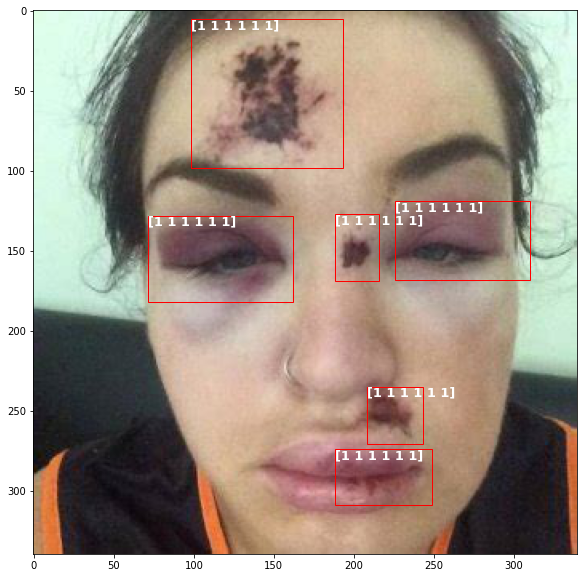

In [20]:
name = df.Image_ID.unique()[0]
plot_image(name)

     xmin  ymin  xmax  ymax
121    89   171   208   295
122   235   337   309   410
     xmin  ymin  xmax  ymax
121    89   171   208   295
122   235   337   309   410


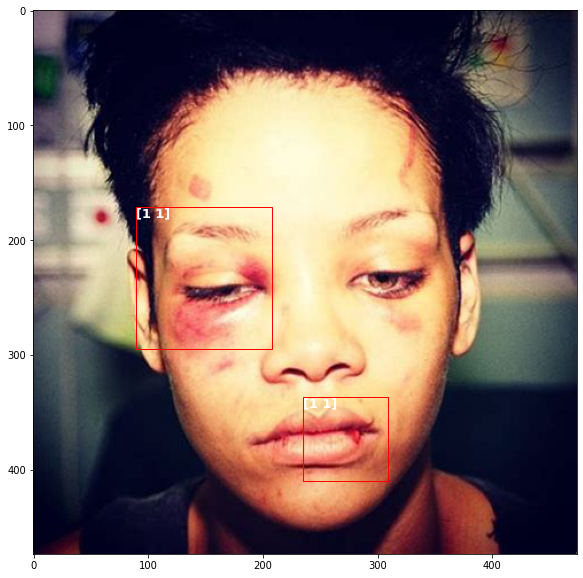

In [21]:
name = df.Image_ID.unique()[70]
plot_image(name)

     xmin  ymin  xmax  ymax
211    85    96   395   504


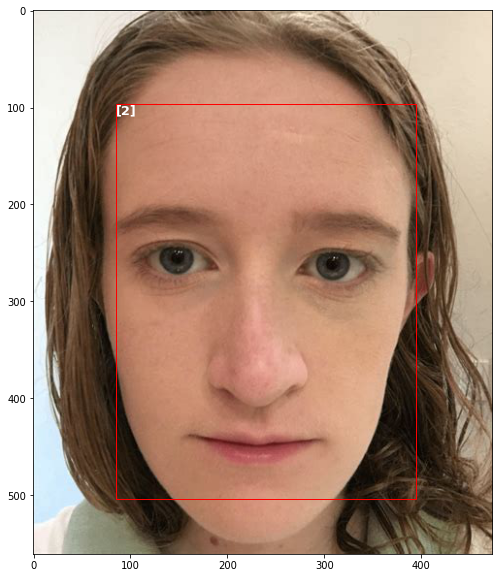

In [22]:
name = df.Image_ID.unique()[130]
plot_image(name)

#### Create a custom dataset

- We'll create a custom dataset to load our images into PyTorch object detector.

- Sample https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

In [23]:
class PassionFruit(object):
    def __init__(self, df, IMG_DIR, transforms): 
        self.df = df
        self.img_dir = IMG_DIR
        self.image_ids = self.df['Image_ID'].unique().tolist()
        self.transforms = transforms
        
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_values = self.df[self.df['Image_ID'] == image_id]
        image = cv2.imread(self.img_dir+image_id+".jpg",cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        boxes = image_values[['xmin', 'ymin', 'xmax', 'ymax']].to_numpy()
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        
        labels = image_values["class"].values
        labels = torch.tensor(labels)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([idx])
        target['area'] = torch.as_tensor(area, dtype=torch.float32)
        target['iscrowd'] = torch.zeros(len(classes_la), dtype=torch.int64)

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
        
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        return torch.tensor(image), target, image_id

- Define the image transformations. We'll use albumentations package: https://albumentations.ai/

In [24]:
! pip install albumentations==0.4.6


     |████████████████████████████████| 117 kB 12.6 MB/s 
     |████████████████████████████████| 948 kB 42.4 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65172 sha256=3cc5e449f796d5580cfcbae2cc8d293092f238ba7fda58f38edcdce3c3d7b5cb
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [25]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

def get_train_transform():
    return A.pytorch.transforms.ToTensorV2 (p=1.0)

def get_valid_transform():
    return A.pytorch.transforms.ToTensorV2 (p=1.0)


- load passion fruit dataset and perform the transormations

In [26]:
passion_dataset = PassionFruit(df, path, get_train_transform())

- Check if the custom dataset object created ealier works

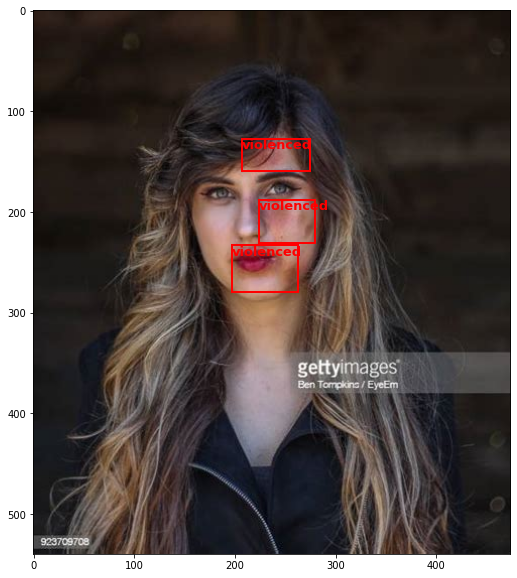

In [28]:
img, tar, _ = passion_dataset[random.randint(0,300)]
bbox = tar['boxes']
fig,ax = plt.subplots(figsize=(18,10))
ax.imshow(img.permute(1,2,0).cpu().numpy())
for l in tar["labels"].tolist():
    classes_la = {1:"violenced",  2:"unviolenced"}
    l = classes_la[l]
    for i in range(len(bbox)):
        box = bbox[i]
        x,y,w,h = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = matplotlib.patches.Rectangle((x,y),w,h,linewidth=2,edgecolor='r',facecolor='none',)
        ax.text(*box[:2], l, verticalalignment='top', color='red', fontsize=13, weight='bold')
        ax.add_patch(rect)
    plt.show()

#### Split data into training and test

In [29]:
image_ids = df['Image_ID'].unique()
valid_ids = image_ids[-93:]
train_ids = image_ids[:-93]
valid_df = df[df['Image_ID'].isin(valid_ids)]
train_df = df[df['Image_ID'].isin(train_ids)]
train_df.shape,valid_df.shape

((347, 8), (114, 8))

### Data Loader

- PyTorch uses dataloader module to make the dataset iterable. We'll pass both the train and val set to the PyTorch DataLoader

In [30]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = PassionFruit(df, path, get_train_transform())
valid_dataset = PassionFruit(df, path, get_valid_transform())

# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

- Most pretrained models are trained with a background class, we'll include it in our model, so in that case our number of classes will be 4

In [32]:
num_classes = 3  # + background

# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

- Train either on GPU if available else CPU 

In [33]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [34]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [35]:
num_epochs = 20

#### Training and evaluation

In [36]:
import sys
best_epoch = 0
min_loss = sys.maxsize

for epoch in range(num_epochs):
    tk = tqdm(train_data_loader)
    model.train();
    for images, targets, image_ids in tk:
        images = list(image.to(device) for image in images)
        targets = [{k: v.long().to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        tk.set_postfix(train_loss=loss_value)
    tk.close()
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()
    
    print(f"Epoch #{epoch} loss: {loss_value}") 
        
    #validation 
    model.eval();
    with torch.no_grad():
        tk = tqdm(valid_data_loader)
        for images, targets, image_ids in tk:
        
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            val_output = model(images)
            val_output = [{k: v.to('cpu') for k, v in t.items()} for t in val_output]
            IOU = []
            for j in range(len(val_output)):
                a,b = val_output[j]['boxes'].cpu().detach(), targets[j]['boxes'].cpu().detach()
                chk = torchvision.ops.box_iou(a,b)
                res = np.nanmean(chk.sum(axis=1)/(chk>0).sum(axis=1))
                IOU.append(res)
            tk.set_postfix(IoU=np.mean(IOU))
        tk.close()

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch #0 loss: 0.2541884779930115


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch #1 loss: 0.20771531760692596


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch #2 loss: 0.18025539815425873


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch #3 loss: 0.17357666790485382


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch #4 loss: 0.17156489193439484


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch #5 loss: 0.16350670158863068


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch #6 loss: 0.15688812732696533


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch #7 loss: 0.1547575294971466


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch #8 loss: 0.15472614765167236


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch #9 loss: 0.1493486911058426


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch #10 loss: 0.14826823770999908


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch #11 loss: 0.15504756569862366


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch #12 loss: 0.1494058221578598


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch #13 loss: 0.15132175385951996


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch #14 loss: 0.1524127721786499


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch #15 loss: 0.15083183348178864


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch #16 loss: 0.15375037491321564


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch #17 loss: 0.1525406539440155


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch #18 loss: 0.15218894183635712


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch #19 loss: 0.15744388103485107


  0%|          | 0/39 [00:00<?, ?it/s]

best epoch is epoch 12

##### Sample evaluation on validation dataset image

In [37]:
img,target,_ = valid_dataset[5]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('predicted #boxes: ', len(prediction['boxes']))
print('real #boxes: ', len(target['boxes']))

predicted #boxes:  36
real #boxes:  3


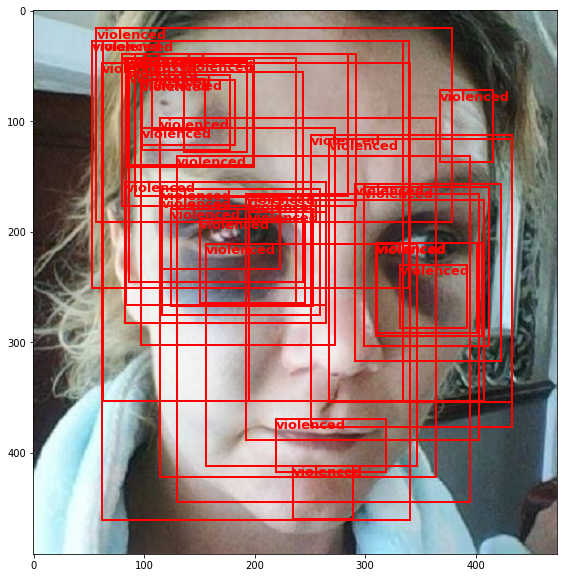

In [39]:
bbox= prediction['boxes']
#bbox = tar['boxes']
fig,ax = plt.subplots(figsize=(18,10))
ax.imshow(img.permute(1,2,0).cpu().numpy())
for l in tar["labels"].tolist():
    classes_la = {1:"violenced",  2:"unviolenced"}
    l = classes_la[l]
    for i in range(len(bbox)):
        box = bbox[i]
        x,y,w,h = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = matplotlib.patches.Rectangle((x,y),w,h,linewidth=2,edgecolor='r',facecolor='none',)
        ax.text(*box[:2], l, verticalalignment='top', color='red', fontsize=13, weight='bold')
        ax.add_patch(rect)
    plt.show()

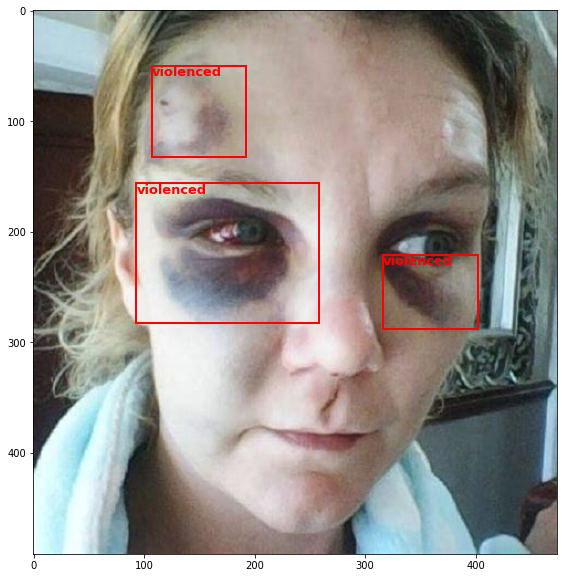

In [40]:
#bbox= prediction['boxes']
bbox = target['boxes']
fig,ax = plt.subplots(figsize=(18,10))
ax.imshow(img.permute(1,2,0).cpu().numpy())
for l in tar["labels"].tolist():
    classes_la = {1:"violenced",  2:"unviolenced"}
    l = classes_la[l]
    for i in range(len(bbox)):
        box = bbox[i]
        x,y,w,h = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = matplotlib.patches.Rectangle((x,y),w,h,linewidth=2,edgecolor='r',facecolor='none',)
        ax.text(*box[:2], l, verticalalignment='top', color='red', fontsize=13, weight='bold')
        ax.add_patch(rect)
    plt.show()

In [38]:
prediction

{'boxes': tensor([[116.2861, 161.5561, 259.3693, 275.2725],
         [310.8194, 210.0748, 401.1474, 291.5602],
         [ 85.3205,  43.7603, 199.5528, 141.3364],
         [129.8535, 131.3027, 395.1110, 444.4055],
         [ 98.0234,  58.3686, 177.2929, 125.5883],
         [298.6978, 159.6398, 412.0943, 303.4618],
         [135.8872,  45.0445, 193.2395, 127.8726],
         [ 97.6048, 105.9693, 272.7670, 302.7387],
         [ 92.0324,  39.3382, 284.1958, 167.8114],
         [290.5529, 157.2030, 422.8051, 317.2218],
         [150.5913, 188.4191, 245.3349, 264.6889],
         [367.7736,  72.1326, 415.9415, 136.7458],
         [ 61.7463,  46.8660, 340.7585, 461.0463],
         [ 96.8872,  62.8712, 182.4550, 121.4952],
         [ 83.0044, 154.6937, 264.8243, 282.9581],
         [219.6074, 369.5150, 318.8810, 417.0941],
         [ 80.0185,  38.9865, 291.4383, 176.8497],
         [267.3111, 116.2399, 433.0016, 354.4381],
         [331.1891, 229.7492, 392.4730, 286.7806],
         [234.5393, 41

## ground truth box for the sample test

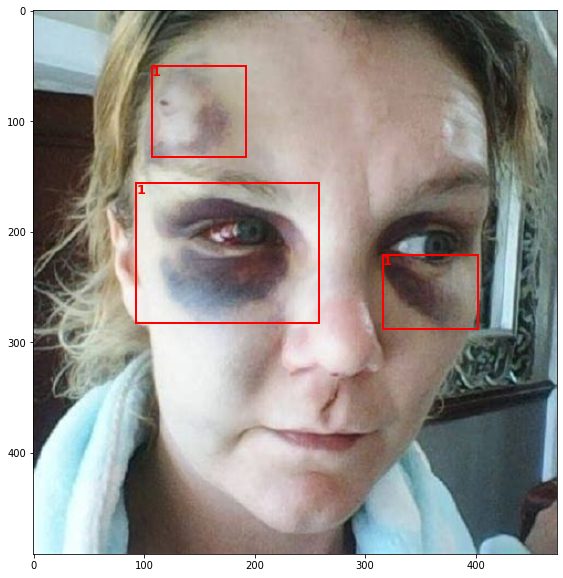

In [41]:
bbox = target['boxes'].numpy()
fig,ax = plt.subplots(1,figsize=(18,10))
ax.imshow(img.permute(1,2,0).cpu().numpy())
for l in target["labels"]:
    for i in range(len(bbox)):
        box = bbox[i]
        x,y,w,h = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = matplotlib.patches.Rectangle((x,y),w,h,linewidth=2,edgecolor='r',facecolor='none',)
        ax.text(*box[:2], l.tolist(), verticalalignment='top', color='red', fontsize=13, weight='bold')
        ax.add_patch(rect)
    plt.show()

## Predicted box for the sample Image

In [42]:
def plot_valid(img,prediction,nms=True,detect_thresh=0.5):
    fig,ax = plt.subplots(figsize=(18,10))
    val_img = img.permute(1,2,0).cpu().numpy()
    ax.imshow(val_img)
    val_scores = prediction['scores'].cpu().detach().numpy()
    bbox = prediction['boxes'].cpu().detach().numpy()
    for l in target["labels"]:
        for i in range(len(bbox)):
            if val_scores[i]>=detect_thresh:
                box = bbox[i]
                x,y,w,h = box[0], box[1], box[2]-box[0], box[3]-box[1]
                rect = matplotlib.patches.Rectangle((x,y),w,h,linewidth=2 ,edgecolor='r',facecolor='none',)
                ax.text(*box[:2], "class " + str(l.tolist()) + " score {0:.3f}".format(val_scores[i]), verticalalignment='top', color='white', fontsize=12, weight='bold')
                ax.add_patch(rect)
        plt.show()

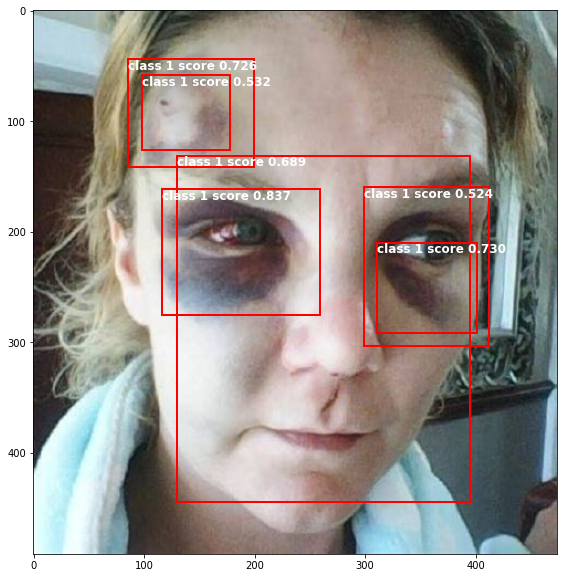

In [43]:
plot_valid(img,prediction)

#### Load the submission images IDs

- We can load them from the test.csv

In [45]:
test_df = pd.read_csv("/content/drive/MyDrive/zindi_gbv/Zindi mentorship program project/Datasets/Test/annos/test_annoations.csv",names=['class','xmin','ymin','width','height','Image_ID','imgW','imgH'])
test_df.head()
#submission = pd.read_csv('Test.csv')

class  xmin  ymin  width  height  Image_ID  imgW  imgH
0  violenced    79   121    208     167  0001.jpg   474   474
1  violenced    27   198    392     301  0002.jpg   474   577
2  violenced   198    60    251     124  0002.jpg   474   577
3  violenced   163   173     71      34  0003.jpg   474   452
4  violenced   198   244     31      25  0003.jpg   474   452

In [46]:
test_df["Image_ID"] = test_df["Image_ID"].apply(lambda x: del_jpg(x))

In [47]:
test_df.head()

class  xmin  ymin  width  height Image_ID  imgW  imgH
0  violenced    79   121    208     167     0001   474   474
1  violenced    27   198    392     301     0002   474   577
2  violenced   198    60    251     124     0002   474   577
3  violenced   163   173     71      34     0003   474   452
4  violenced   198   244     31      25     0003   474   452

In [48]:
test_df['xmax'] = test_df['xmin']+test_df['width']
test_df['ymax'] = test_df['ymin']+test_df['height']

In [49]:
test_df

class  xmin  ymin  width  height Image_ID  imgW  imgH  xmax  ymax
0     violenced    79   121    208     167     0001   474   474   287   288
1     violenced    27   198    392     301     0002   474   577   419   499
2     violenced   198    60    251     124     0002   474   577   449   184
3     violenced   163   173     71      34     0003   474   452   234   207
4     violenced   198   244     31      25     0003   474   452   229   269
..          ...   ...   ...    ...     ...      ...   ...   ...   ...   ...
69    violenced   195   371     97      70     0057   474   509   292   441
70  unviolenced    94    46    303     329     0061   474   515   397   375
71    violenced   174    37    139     152     0062   336   280   313   189
72  unviolenced   161    40    229     225     0063   474   474   390   265
73    violenced    75    59     61      56     0064   200   193   136   115

[74 rows x 10 columns]

In [50]:
submission= test_df["Image_ID"]

## Create a custom dataset for the test set

In [51]:
class TestDataset(object):
    def __init__(self, df, IMG_DIR, transforms):        
        self.df = df
        self.img_dir = IMG_DIR
        self.transforms = transforms
        self.image_ids = self.df['Image_ID'].tolist()
        
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):        
        image_id = self.image_ids[idx]
        image = cv2.imread(self.img_dir+image_id+".jpg",cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        
        if self.transforms:
            sample = {
                'image': image,
            }
            sample = self.transforms(**sample)
            image = sample['image']
        return image, image_id

### Apply transformation

In [52]:
def get_test_transform(IMG_SIZE=(512,512)):
    return A.Compose([
         A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255.0, p=1.0),
        A.Resize(*IMG_SIZE),
        ToTensorV2(p=1.0)
    ])

In [56]:
test_img_dir = '/content/drive/MyDrive/zindi_gbv/Zindi mentorship program project/Datasets/Test/images/'

- The training images were of size 515 x 512, resize the test images to the same dimensions.

In [57]:
IMG_SIZE = (512,512)

In [59]:
test_dataset = TestDataset(test_df, test_img_dir ,get_test_transform())

### Predicting on testset,  create submission

In [60]:
results = []
for j in range(submission.shape[0]):
    
    img,_ = test_dataset[j]
    img = img.unsqueeze_(0)
    # put the model in evaluation mode
    model.eval()

    with torch.no_grad():
        prediction = model([img.to(device)][0])
        aa = zip(prediction[0]["boxes"].tolist(), prediction[0]["labels"].tolist(), prediction[0]["scores"].tolist())
       
        for item in list(aa):
            row_dict = {}
            row_dict["Image_ID"] = _
            row_dict["boxes"] = item[0]
            row_dict["labels"] = item[1]
            row_dict["confidence"] = item[2]
            results.append(row_dict)
sub_df = pd.DataFrame(results)

In [61]:
sub_df["ymin"] = sub_df["boxes"].apply(lambda x: x[1])
sub_df["xmin"] = sub_df["boxes"].apply(lambda x: x[0])
sub_df["ymax"] = sub_df["boxes"].apply(lambda x: x[3])
sub_df["xmax"]=  sub_df["boxes"].apply(lambda x: x[2])

In [62]:
classes_la = {0:"Background", 1:"violenced", 2:"unviolenced"}
sub_df["labels"] = sub_df["labels"].apply(lambda x: classes_la[x])

In [63]:
sub_df.drop(["boxes"], axis=1, inplace=True)

In [64]:
sub_df.rename(columns={"labels":"class"}, inplace=True)

In [65]:
sub_df.head()

Image_ID        class  confidence  ...        xmin        ymax        xmax
0     0001    violenced    0.548439  ...  117.420799  298.912994  295.704315
1     0001  unviolenced    0.466018  ...   98.117104  442.871460  414.289185
2     0001    violenced    0.220427  ...  201.425842  408.120544  318.134277
3     0001  unviolenced    0.201286  ...  100.076004  307.774689  313.161346
4     0001    violenced    0.173140  ...  104.026947  372.956970  329.819489

[5 rows x 7 columns]

In [66]:
sub_df.shape

(1419, 7)

In [67]:
sub_df.to_csv("/content/drive/MyDrive/zindi_gbv/Zindi mentorship program project/Datasets/GBV_violence_prediction.csv", index=False)